In [1]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime, time
from django.utils import timezone
import pytz
from alive_progress import alive_bar

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 400)

# import data
df_spec = pd.read_pickle('.\\calculations\\df_spec.pickle')
df_bio = pd.read_pickle('.\\calculations\\df_hist.pickle')
df_arch = pd.read_pickle('.\\calculations\\df_arch.pickle')

# Initial Potential Problem from The Dataset

In [2]:
# these are the problems that I noticed. They are the only 6 import issue in samples with both spec and bio entries (this dataset).
problems = ['GD_2367', 'GD_2368', 'GD_3039', 'GD_3040', 'GD_3041', 'GD_3042']
df_arch[df_arch.old_id.isin(problems)].BIOLOGICAL_SAMPLE.value_counts()

1.000    6
Name: BIOLOGICAL_SAMPLE, dtype: int64

In [3]:
# they are the only entries in the specimen table with sex_id (in this dataset)
df_spec.notna().sum()

id                      74666
fork_length             74447
weight                    429
river_age               74664
notes                   74666
sample_id               74666
sex_id                      6
status_id               74666
age_type                74664
sweep_id                74666
life_stage_id           74666
old_id                  74666
smart_river_age         74664
smart_river_age_type    74664
matching_id             74666
dtype: int64

# The Import Script

the old version of the import:
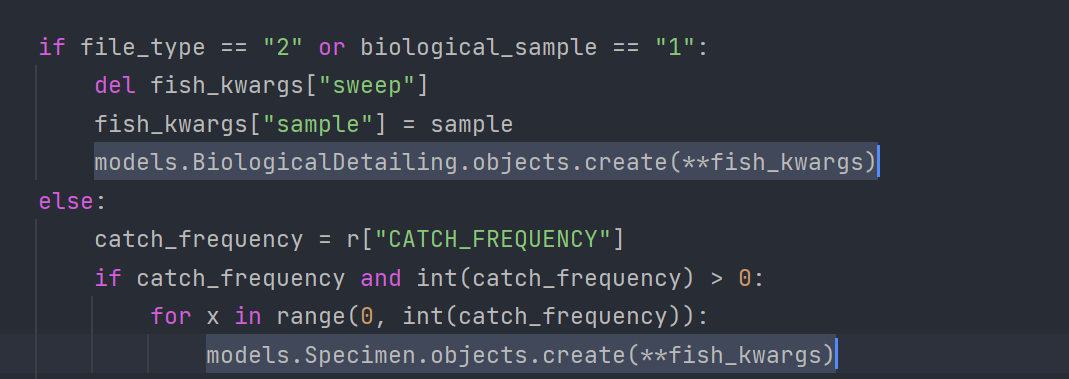

the newer version of the import (where the potential error ocurred):
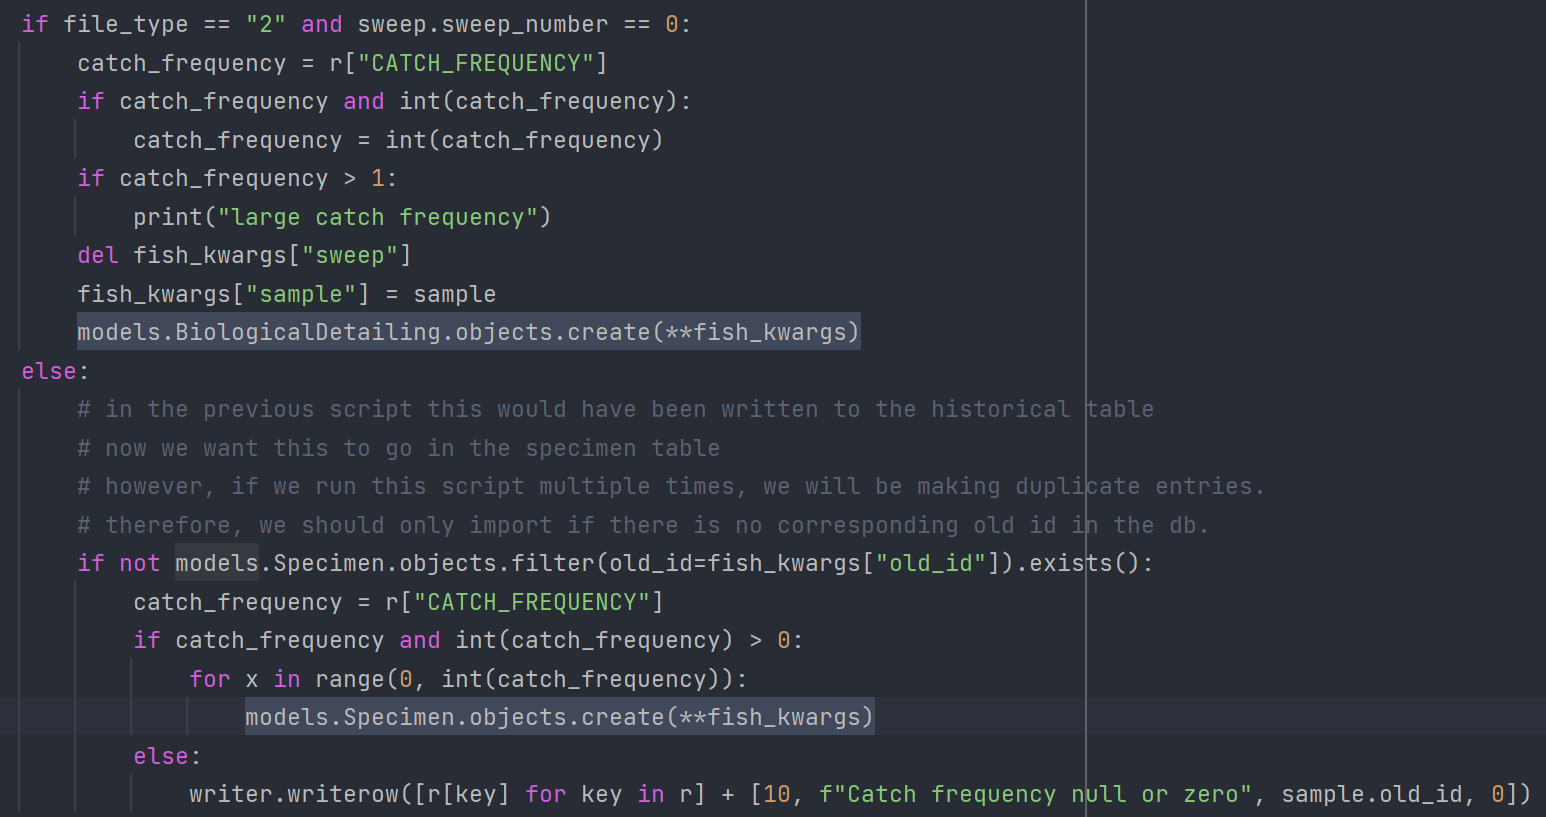

* this script only considers samples with 
        
        file_type == '2' or biological_sample == '1'
* the problem imports occured because file_type was Null (even though sweep_number == 0)
    * potential fix could involve finding null filetype and changing mapping sweep==0 to filetype==2, and sweep>0 to filetype==1
    * or potentially ignoring filetype for this check?

In [4]:
df_arch.FILE_TYPE.value_counts(dropna=False)

NaN      233287
1.000     50527
2.000     37686
Name: FILE_TYPE, dtype: int64

# Information About Parameters

what is file_type==2?
    
* FILE_TYPE: either 1 (regular sample) or 2 (biological sample)

what is sweep_number==0?

* SWEEP_NUMBER: if successive removal, values from 1 to 6, if single/CPUE pass value = 0.5,
if non-monitoring sampling sweep =0, notes that certain sites are ‘calibration sites’ i.e. a cpue pass is conducted followed by several successive removal passes

* SWEEP_number = 0 Sites; if there are no SWEEP0_TIME, in that site a subsample of the fish caught during the various sweep was measures to the closest mm and sometimes weighted and/or sacrificed for sexing. Unfortunately the sweep during which these fish were caught was not recorded. For these sites its important to not include sweep_number = 0 fish to the total number of fish caught during the various sweeps.


# Exploratory Analysis

In [5]:
df_arch[df_arch.old_id.isin(problems)].T.drop(['BIOLOGICAL_REMARKS', 'arch_matching_id'])
# FILE_TYPE = NaN caused the import issue

,2366,2367,3038,3039,3040,3041
old_id,GD_2367,GD_2368,GD_3039,GD_3040,GD_3041,GD_3042
DATETIME,1971-09-08 00:00:00,1971-09-08 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00
SURVEY,1971,1971,1971,1971,1971,1971
SITE,13,13,58,58,58,58
CATCHMENT_NAME,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI
CATCHMENT_INDEX,2,2,2,2,2,2
SURVEY_TYPE,1,1,1,1,1,1
SITE_EVENT_CODE,1,1,1,1,1,1
SWEEP_NUMBER,0.000,0.000,0.000,0.000,0.000,0.000
RECORD_IDENTIFIER,8628334,8628335,8626673,8626674,8626675,8626676


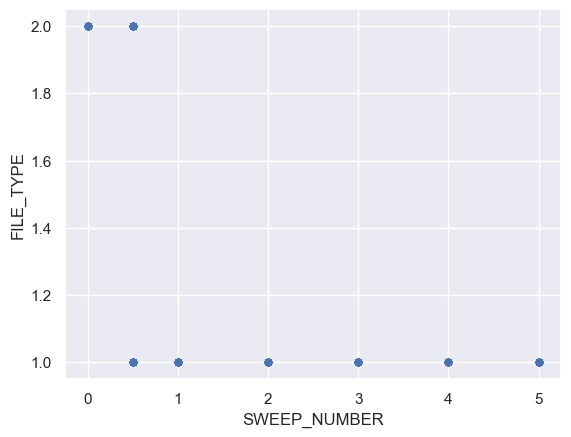

In [6]:
# how does sweep compare with file_type?
#  it looks like anythin with sweep_number==0 should count as file_type==2
df_arch.plot(kind='scatter', y='FILE_TYPE', x='SWEEP_NUMBER');

In [7]:
# potential import problems
df_arch[
    (df_arch.SWEEP_NUMBER==0) 
    & (df_arch.FILE_TYPE.isnull()) 
    & (df_arch.BIOLOGICAL_SAMPLE==1) 
    & (df_arch.SEX.notnull())
].describe().T

,count,mean,std,min,25%,50%,75%,max
SURVEY,20.000,1970.300,0.470,1970.000,1970.000,1970.000,1971.000,1971.000
CATCHMENT_INDEX,20.000,2.000,0.000,2.000,2.000,2.000,2.000,2.000
SURVEY_TYPE,20.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
SITE_EVENT_CODE,20.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
SWEEP_NUMBER,20.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
SPECIES_LIFE_STAGE,20.000,1731.000,0.000,1731.000,1731.000,1731.000,1731.000,1731.000
FORK_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH_INTERVAL_WIDTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# out of samples with bio data, only these 6 have been imported into spec which also include bio detailing
#  sweep==0 & file_type==NULL
df_spec[
    df_spec.old_id.isin(
       df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
        ].old_id.unique()
    )
].drop('notes', axis=1)

,id,fork_length,weight,river_age,sample_id,sex_id,status_id,age_type,sweep_id,life_stage_id,old_id,smart_river_age,smart_river_age_type,matching_id
2259,2230972,<NA>,NaN,0.000,4456,1,5.000,1.000,14123.000,11.000,GD_2367,0.000,1.000,445600_01
2260,2230973,<NA>,NaN,0.000,4456,1,5.000,1.000,14123.000,11.000,GD_2368,0.000,1.000,445600_01
2696,2233822,<NA>,NaN,1.000,4475,2,4.000,1.000,14139.000,1.000,GD_3039,1.000,1.000,447500_02
2697,2233823,<NA>,NaN,1.000,4475,2,4.000,1.000,14139.000,1.000,GD_3040,1.000,1.000,447500_02
2698,2233824,<NA>,NaN,1.000,4475,2,4.000,1.000,14139.000,1.000,GD_3041,1.000,1.000,447500_02
2699,2233825,<NA>,NaN,1.000,4475,1,4.000,1.000,14139.000,1.000,GD_3042,1.000,1.000,447500_01


In [9]:
# however, we should check the full dataset to see if there are any other potential for problem imports
df_all = pd.read_csv('.\\raw_data\\trapnet_specimen_202302231329.csv', low_memory=False)

df_checkthis = df_all[
    df_all.old_id.isin(
        df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
            & (df_arch.BIOLOGICAL_SAMPLE==1) 
        ].old_id.unique()
    )
].copy()

# 150 potential issues, 20 have sex info, 0 have maturity
# 0 have fork_length or weight
#  therefore aren't affecting any length or weight distributions if double counted
df_checkthis.describe().T

,count,mean,std,min,25%,50%,75%,max
id,150.000,2223953.127,2207.735,2221796.000,2222811.250,2223425.500,2224420.250,2233825.000
fork_length,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_length,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
river_age,150.000,1.627,0.608,0.000,1.000,2.000,2.000,3.000
created_by_id,150.000,50.000,0.000,50.000,50.000,50.000,50.000,50.000
origin_id,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_id,150.000,4422.840,11.064,4413.000,4416.000,4421.000,4425.750,4475.000
sex_id,20.000,1.350,0.489,1.000,1.000,1.000,2.000,2.000
species_id,150.000,79.000,0.000,79.000,79.000,79.000,79.000,79.000


In [10]:
# compare ratios of non-null values between full dataset and potential problem imports
df_comparison = pd.concat([
    pd.DataFrame(df_checkthis.notnull().sum() / df_checkthis.shape[0], columns=['prop_filtered']),
    pd.DataFrame(df_all.notnull().sum() / df_all.shape[0], columns=['prop_all']),
    pd.DataFrame(df_checkthis.notnull().sum() / df_checkthis.shape[0], columns=['difference']) / \
    pd.DataFrame(df_all.notnull().sum() / df_all.shape[0], columns=['difference'])
], axis=1)

In [11]:
# differences between data to check and full dataset, sorted largest to smallest difference
df_comparison.sort_values('difference', ascending=False)

,prop_filtered,prop_all,difference
sex_id,0.133,0.013,9.943
age_type,1.000,0.390,2.566
smart_river_age_type,1.000,0.392,2.548
river_age,1.000,0.401,2.496
smart_river_age,1.000,0.403,2.482
life_stage_id,1.000,0.598,1.673
old_id,1.000,0.724,1.382
adipose_condition,1.000,0.725,1.380
sweep_id,1.000,0.738,1.356
updated_by_id,1.000,0.741,1.350


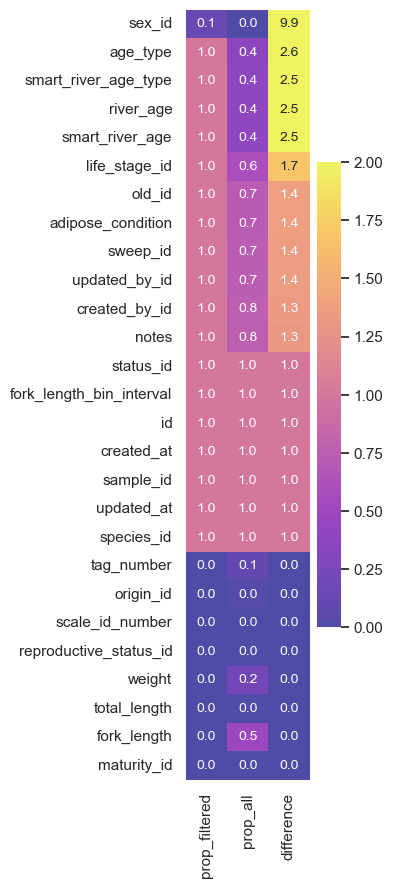

In [12]:
plt.figure(figsize=(2,10))
sns.heatmap(df_comparison.sort_values('difference', ascending=False).dropna(), vmin=0, vmax=2, cmap='plasma', alpha=0.7, annot=True, fmt='.1f', annot_kws={"fontsize":10})
plt.show()

In [13]:
# what about sweep 0.5?

df_all[
    df_all.old_id.isin(
        df_arch[
            ((df_arch.SWEEP_NUMBER==0) | (df_arch.SWEEP_NUMBER==0.5))
            & (df_arch.FILE_TYPE.isnull()) 
            & (df_arch.BIOLOGICAL_SAMPLE==1) 
        ].old_id.unique()
    )
].shape, df_checkthis.shape

# no new specimen to check

((150, 28), (150, 28))

In [14]:
# what are the status id for these entries
df_checkthis.status_id.value_counts()

5.000    134
4.000     16
Name: status_id, dtype: int64

In [15]:
# what are the average proportions for different statuses in the entire archived dataset?
df_arch.FISH_STATUS.value_counts()

RS    287939
R      24929
MZ      6055
M       2539
RL        12
           1
Y          1
Name: FISH_STATUS, dtype: int64

In [16]:
# 4 and 5 are from the problem imports, they equate to:
#   MZ (4: 'mortality research removal (fish euthanasied)' ) and 
#   R (5: 'released unsampled')

# why do they have sex and age data if they are unsampled?
display(df_checkthis.value_counts('river_age'))
display(df_checkthis.value_counts('sex_id'))

river_age
2.000    80
1.000    60
3.000     8
0.000     2
dtype: int64

sex_id
1.000    13
2.000     7
dtype: int64

In [17]:
# are all of the sex and age data from the MZ? (no)

#  all R ('released unsampled') specimen have age, and 4 have sex
#  none have length or weight

df_all[
    df_all.old_id.isin(
        df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
            & (df_arch.BIOLOGICAL_SAMPLE==1) 
            & (df_arch.FISH_STATUS=='R') 
        ].old_id.unique()
    )
][['id', 'fork_length', 'weight', 'sex_id', 'river_age']].describe()

,id,fork_length,weight,sex_id,river_age
count,134.000,0.000,0.000,4.000,134.000
mean,2223705.694,NaN,NaN,1.000,1.619
std,1490.502,NaN,NaN,0.000,0.623
min,2221796.000,NaN,NaN,1.000,0.000
25%,2222807.250,NaN,NaN,1.000,1.000
50%,2223428.500,NaN,NaN,1.000,2.000
75%,2224318.750,NaN,NaN,1.000,2.000
max,2230973.000,NaN,NaN,1.000,3.000


In [18]:
#  all MZ have sex and age
#  none have length or weight

df_all[
    df_all.old_id.isin(
        df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
            & (df_arch.BIOLOGICAL_SAMPLE==1) 
            & (df_arch.FISH_STATUS=='MZ') 
        ].old_id.unique()
    )
][['id', 'fork_length', 'weight', 'sex_id', 'river_age']].describe()

,id,fork_length,weight,sex_id,river_age
count,16.000,0.000,0.000,16.000,16.000
mean,2226025.375,NaN,NaN,1.438,1.688
std,4856.997,NaN,NaN,0.512,0.479
min,2222948.000,NaN,NaN,1.000,1.000
25%,2222951.750,NaN,NaN,1.000,1.000
50%,2222955.500,NaN,NaN,1.000,2.000
75%,2229927.250,NaN,NaN,2.000,2.000
max,2233825.000,NaN,NaN,2.000,2.000


# Are there situations where sweep_number==0 is NOT a biological specimen?

In [19]:
# there are no filetype==1 & sweep==0 in the archived data
# ignoring the filetype may have fixed the above problem

(
    df_arch[
        (df_arch.SWEEP_NUMBER==0)
        & (df_arch.FILE_TYPE==1)
    ].shape[0], 
    df_arch[
        (df_arch.SWEEP_NUMBER==0)
        & (df_arch.BIOLOGICAL_SAMPLE==0)
    ].shape[0]
)
# filetype==1, biosample==0

(0, 116)

In [20]:
# none of these are in checkthis data
df_checkthistoo = df_arch[
    (df_arch.SWEEP_NUMBER==0)
    & (df_arch.BIOLOGICAL_SAMPLE==0)
    & (~df_arch.old_id.isin(df_checkthis.old_id))
]

df_checkthistoo.drop(['DATETIME', 'BIOLOGICAL_REMARKS', 'arch_matching_id', 'GD_ID'], axis=1).describe(include='all').T.sort_index()

# these look like the should be classified as BIOLOGICAL_SAMPLE==1: most have sex data, all have river_age, most have weight

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
AGE_TYPE,116,1,SCALE,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BIOLOGICAL_SAMPLE,116.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000
CATCHMENT_INDEX,116.000,NaN,NaN,NaN,2.000,0.000,2.000,2.000,2.000,2.000,2.000
CATCHMENT_NAME,116,1,MIRAMICHI,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CATCH_FREQUENCY,116.000,NaN,NaN,NaN,1.000,0.000,1.000,1.000,1.000,1.000,1.000
FILE_TYPE,116.000,NaN,NaN,NaN,2.000,0.000,2.000,2.000,2.000,2.000,2.000
FISH_SIZE,115,2,PARR,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_STATUS,116,2,MZ,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH,116.000,NaN,NaN,NaN,88.121,27.052,41.000,63.000,90.000,105.000,153.000
FORK_LENGTH_INTERVAL_WIDTH,116.000,NaN,NaN,NaN,1.000,0.000,1.000,1.000,1.000,1.000,1.000


In [21]:
# are these in the production database?
df_all[df_all.old_id.isin(df_checkthistoo.old_id.unique())].shape, df_bio[df_bio.old_id.isin(df_checkthistoo.old_id.unique())].shape

# they have been correctly categorised as bio samples in the production database

((0, 28), (116, 13))

# Conclusions and Recommendations
* Since none of these potential problem fish have length or width, they likely are not adversely affecting the data.
* During import, imputing null filetype by mapping sweep==0 to filetype==2 and sweep>0 to filetype==1 could have worked.
    * However, re-import does not appear to be as useful solution, and is not recommended.
* There are two potential recommended solutions:
    1. Leave the data as is.
    2. Transfer all of the fish (listed below) from the 'specimen' table into the 'biologicaldetailing' table.

# Summary of Potential Problems (fish and samples)

In [22]:
# here are our potential problem fish
for i, item in enumerate(sorted(list(df_checkthis.id.unique()))):
    if i % 15 == 0:
        print()
    print(item, end=' ')


2221796 2221797 2221798 2221799 2221800 2221801 2221802 2221803 2221804 2221805 2221806 2221807 2222021 2222022 2222023 
2222024 2222025 2222026 2222027 2222028 2222392 2222393 2222394 2222395 2222396 2222397 2222398 2222399 2222400 2222401 
2222804 2222805 2222806 2222807 2222808 2222809 2222810 2222811 2222812 2222948 2222949 2222950 2222951 2222952 2222953 
2222954 2222955 2222956 2222957 2222958 2223075 2223076 2223077 2223078 2223079 2223080 2223081 2223082 2223083 2223287 
2223288 2223289 2223290 2223291 2223292 2223293 2223294 2223295 2223296 2223412 2223413 2223414 2223423 2223424 2223425 
2223426 2223427 2223428 2223429 2223616 2223617 2223618 2223619 2223620 2223621 2223622 2223623 2223624 2223625 2223862 
2223863 2223864 2223865 2223866 2223867 2223868 2223869 2223870 2223974 2223975 2223976 2223977 2224310 2224311 2224312 
2224313 2224314 2224315 2224316 2224317 2224318 2224319 2224454 2224455 2224456 2224457 2224458 2224459 2224460 2224461 
2224462 2224463 2224575 2224576

In [23]:
# here are our potential problem samples
for item in sorted(list(df_checkthis.sample_id.unique())):
    print(item, end=' ')

4413 4414 4415 4416 4417 4418 4419 4420 4421 4422 4423 4424 4425 4426 4428 4430 4431 4438 4456 4475 